In [85]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#survival analysis lib
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.utils import restricted_mean_survival_time, k_fold_cross_validation


In [5]:
telco = pd.read_csv('../data/telco_clustered.csv')
pd.set_option('display.max_columns',99)

In [6]:
telco = telco.drop(columns=['city', 'cltv','churn_reason','churn_category', 'internet_type','pop_density', 'tenure_months', 'dependents'])

In [7]:
telco.head()

,gender,age,under_30,senior_citizen,married,number_of_dependents,phone_service,multiple_lines,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,contract,paperless_billing,payment_method,churn_value,churn_score,referred_a_friend,number_of_referrals,tenure_in_months,offer,avg_monthly_long_distance_charges,avg_monthly_gb_download,streaming_music,unlimited_data,monthly_charge,total_charges,total_refunds,total_extra_data_charges,total_long_distance_charges,total_revenue,satisfaction_score,customer_status,new_user,cluster
0,0,78,0,1,0,0,0,0,DSL,0,0,1,0,0,1,1,1,Electronic check,1,100,0,0,1,None,0.00,8,0,0,39.65,39.65,0.00,20,0.00,59.65,3,1,0,vanilla
1,1,74,0,1,1,1,1,1,Fiber optic,0,1,0,0,0,0,1,1,Credit card (automatic),1,69,1,1,8,Offer E,48.85,17,0,1,80.65,633.30,0.00,0,390.80,1024.10,3,1,0,price_sensitive
2,0,71,0,1,0,3,1,1,Fiber optic,0,0,0,0,1,1,1,1,Electronic check,1,81,0,0,18,Offer D,11.33,52,1,1,95.45,1752.55,45.61,0,203.94,1910.88,2,1,0,price_sensitive
3,1,78,0,1,1,1,1,0,Fiber optic,0,1,1,0,1,1,1,1,Electronic check,1,88,1,1,25,Offer C,19.76,12,0,1,98.50,2514.50,13.43,0,494.00,2995.07,2,1,0,price_sensitive
4,1,80,0,1,1,1,1,1,Fiber optic,0,0,0,0,0,0,1,1,Electronic check,1,67,1,1,37,Offer C,6.33,14,0,1,76.50,2868.15,0.00,0,234.21,3102.36,2,1,0,price_sensitive


## OHE

In [8]:
telco_dummies = pd.get_dummies(telco, drop_first=True)

## Survival Analysis

### Kaplan Meier

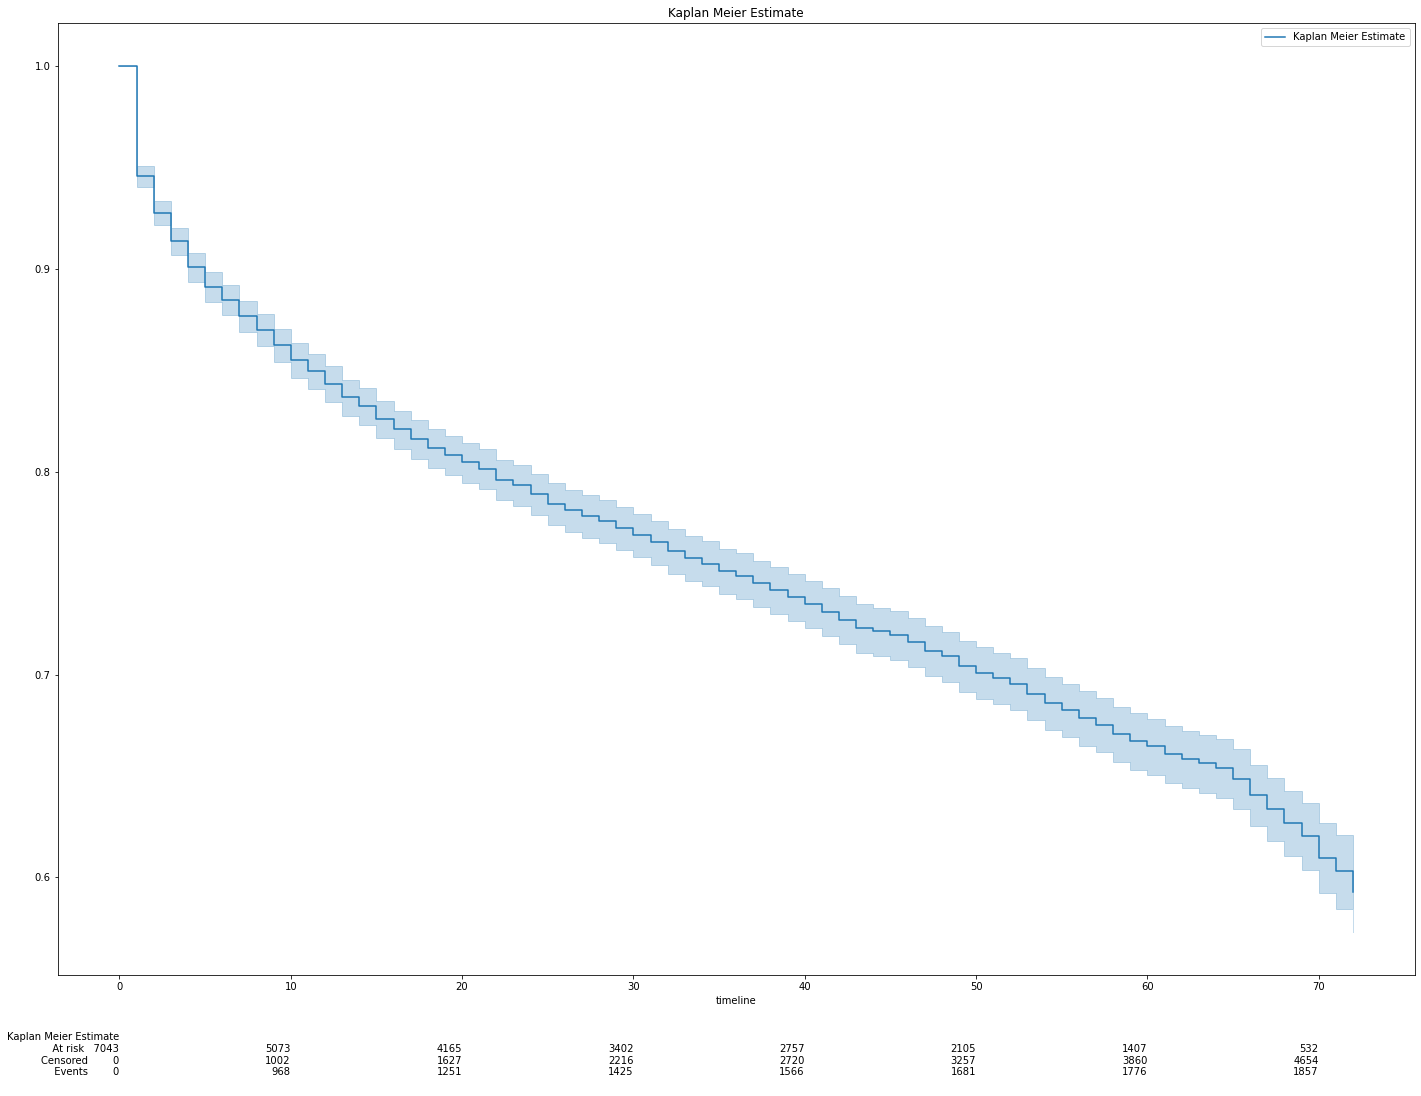

In [9]:
duration = telco['tenure_in_months'] 
event_observed = telco['customer_status']  

# instantiate km
km = KaplanMeierFitter() 

#plot figure
plt.figure(figsize=(20,15))
# Fit
km.fit(duration, event_observed,label='Kaplan Meier Estimate')

# Create an estimate
km.plot_survival_function(at_risk_counts=True)

plt.title('Kaplan Meier Estimate')
plt.show()

In [10]:
km.median_survival_time_

inf

Restricted Mean Survival Time Vanilla: 38.66696155448072
Restricted Mean Survival Time Breadwinner: 49.80325474096202
Restricted Mean Survival Time Carefree: 46.53044679114264
Restricted Mean Survival Time Price Sensitive: 24.774077527996333


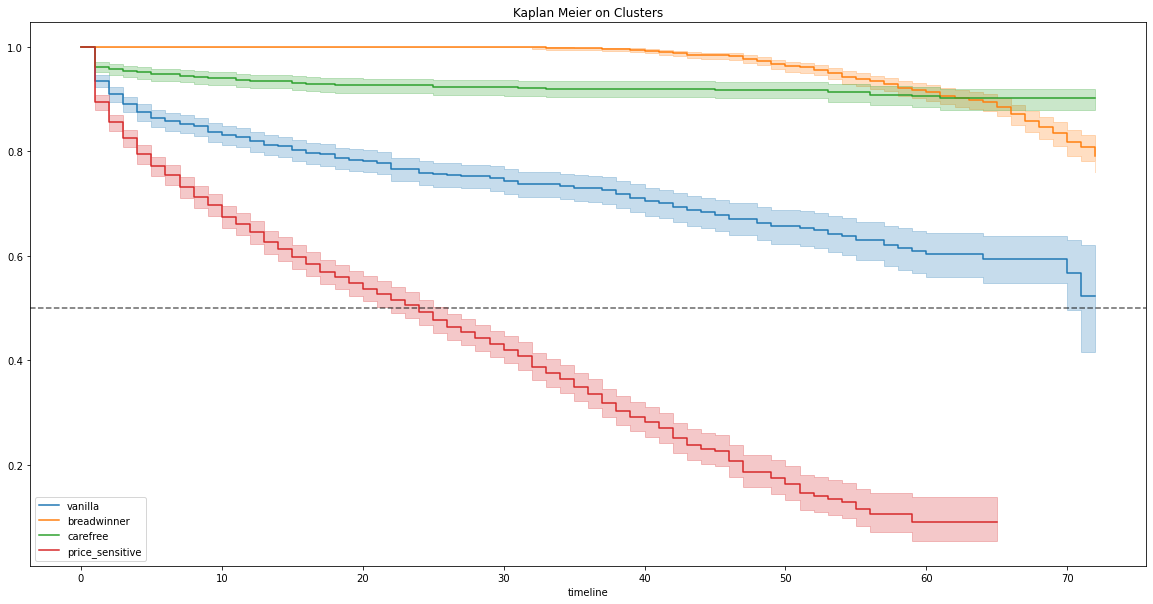

In [69]:
#instantiater
kmf = KaplanMeierFitter() 

T = telco['tenure_in_months']      #time to the event
E = telco['customer_status']    #event occurred or censored
  
#cohorts
x1 = (telco['cluster']  == 'vanilla')   
x2 = (telco['cluster']  == 'breadwinner')    
x3 = (telco['cluster']  == 'carefree')        
x4 = (telco['cluster']  == 'price_sensitive')  

#define time limit 
time_limit = 50

#plot figure
plt.figure(figsize=(20,10))

kmf_v = kmf.fit(T[x1], E[x1], label='vanilla')  
rmst_v = restricted_mean_survival_time(kmf_v, t=time_limit)
print(f'Restricted Mean Survival Time Vanilla: {rmst_v}')
ax = kmf.plot()

kmf_b = kmf.fit(T[x2], E[x2], label='breadwinner')  
rmst_b = restricted_mean_survival_time(kmf_b, t=time_limit)
print(f'Restricted Mean Survival Time Breadwinner: {rmst_b}')
ax1 = kmf.plot(ax=ax)

kmf_c = kmf.fit(T[x3], E[x3], label='carefree') 
rmst_c = restricted_mean_survival_time(kmf_c, t=time_limit)
print(f'Restricted Mean Survival Time Carefree: {rmst_c}')
ax2 = kmf.plot(ax=ax1)  

kmf_p = kmf.fit(T[x4], E[x4], label='price_sensitive')   
rmst_p = restricted_mean_survival_time(kmf_p, t=time_limit)
print(f'Restricted Mean Survival Time Price Sensitive: {rmst_p}')
kmf.plot(ax=ax2)  

plt.axhline(y=0.5, c='k', alpha=0.6, linestyle='--')
plt.title('Kaplan Meier on Clusters')
plt.legend(loc='lower left')
plt.show()

### Cox Proportional Hazard Model 

In [24]:
telco.columns

Index(['gender', 'age', 'under_30', 'senior_citizen', 'married',
       'number_of_dependents', 'phone_service', 'multiple_lines',
       'internet_service', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies',
       'contract', 'paperless_billing', 'payment_method', 'churn_value',
       'churn_score', 'referred_a_friend', 'number_of_referrals',
       'tenure_in_months', 'offer', 'avg_monthly_long_distance_charges',
       'avg_monthly_gb_download', 'streaming_music', 'unlimited_data',
       'monthly_charge', 'total_charges', 'total_refunds',
       'total_extra_data_charges', 'total_long_distance_charges',
       'total_revenue', 'satisfaction_score', 'customer_status', 'new_user',
       'cluster'],
      dtype='object')

In [42]:
cph = CoxPHFitter()

cph.fit(telco_dummies, duration_col='tenure_in_months', event_col='customer_status', 
       formula="gender + senior_citizen + married + number_of_dependents  + multiple_lines + online_security + online_backup + device_protection + tech_support + contract + paperless_billing + satisfaction_score + monthly_charge")


<lifelines.CoxPHFitter: fitted with 7043 total observations, 5174 right-censored observations>

In [43]:
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 7043 total observations, 5174 right-censored observations>
             duration col = 'tenure_in_months'
                event col = 'customer_status'
      baseline estimation = breslow
   number of observations = 7043
number of events observed = 1869
   partial log-likelihood = -12746.04
         time fit was run = 2021-05-12 08:21:15 UTC

---
                       coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                    
contract              -0.13       0.88       0.01            -0.14            -0.12                 0.87                 0.89
device_protection     -0.34       0.71       0.06            -0.45            -0.23                 0.64                 0.79
gender                 0.13       1.14       0.05             0.04             0.22                 1.04                 1.25
married               -0.52       0.59       0.05            -0.62            -0.42                 0.54                 0.66
monthly_charge         0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
multiple_lines        -0.57       0.56       0.06            -0.69            -0.46                 0.50                 0.63
number_of_dependents  -0.19       0.82       0.05            -0.29            -0.10                 0.75                 0.91
online_backup         -0.58       0.56       0.06            -0.69            -0.47                 0.50                 0.62
online_security       -0.83       0.44       0.07            -0.96            -0.70                 0.38                 0.50
paperless_billing      0.00       1.00       0.06            -0.11             0.12                 0.90                 1.12
satisfaction_score    -1.05       0.35       0.02            -1.09            -1.00                 0.33                 0.37
senior_citizen        -0.19       0.83       0.06            -0.30            -0.08                 0.74                 0.92
tech_support          -0.22       0.80       0.07            -0.35            -0.10                 0.70                 0.91

                          z      p   -log2(p)
covariate                                    
contract             -21.72 <0.005     345.04
device_protection     -6.17 <0.005      30.41
gender                 2.83 <0.005       7.73
married              -10.17 <0.005      78.36
monthly_charge         1.19   0.23       2.10
multiple_lines       -10.11 <0.005      77.48
number_of_dependents  -4.01 <0.005      14.02
online_backup        -10.41 <0.005      81.93
online_security      -12.64 <0.005     119.19
paperless_billing      0.06   0.96       0.07
satisfaction_score   -41.96 <0.005        inf
senior_citizen        -3.36 <0.005      10.34
tech_support          -3.43 <0.005      10.68
---
Concordance = 0.93
Partial AIC = 25518.08
log-likelihood ratio test = 5817.44 on 13 df
-log2(p) of ll-ratio test = inf

<AxesSubplot:xlabel='log(HR) (95% CI)'>

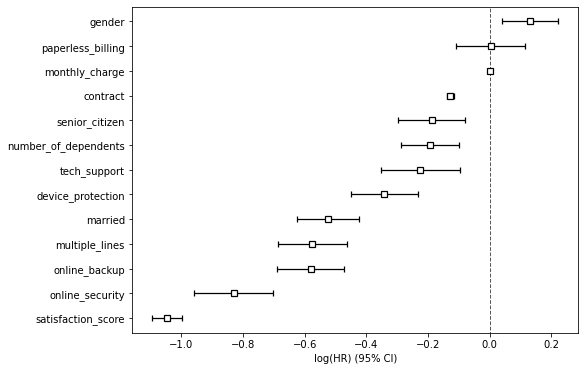

In [44]:
ax = plt.subplots(figsize=(8, 6))
cph.plot(ax=ax[1])